In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LocalAttention(nn.Module):
    """
    ローカルアテンションのPyTorch実装。
    各トークンは、その周囲の 'window_size' 内のトークンにのみ注目します。
    """
    def __init__(self, d_model, window_size):
        super().__init__()
        self.d_model = d_model
        # window_sizeは奇数を推奨 (例: 5 -> 自分+前後2)
        self.window_size = window_size

        # Q, K, V の線形変換層（シングルヘッドとして簡略化）
        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)

    def forward(self, x):
        # x の形状: (batch_size, seq_len, d_model)
        batch_size, seq_len, d_model = x.shape

        # 1. Q, K, V の計算
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        # 2. アテンションスコア（Q * K^T）の計算
        # scores の形状: (batch_size, seq_len, seq_len)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (d_model ** 0.5)

        # 3. ローカルアテンションマスクの作成

        # half_window: 各トークンの片側（左右）に注目するトークン数
        # 例: window_size=5 の場合, half_window = 2 (自分 + 前2 + 後2)
        half_window = (self.window_size - 1) // 2

        # 距離行列の作成: (seq_len, seq_len)
        # i行j列の値は |i - j| (インデックス i と j の距離)
        i = torch.arange(seq_len, device=x.device).unsqueeze(1)
        j = torch.arange(seq_len, device=x.device).unsqueeze(0)
        distance_matrix = torch.abs(i - j)

        # ローカルマスク: 距離が half_window 以下なら True (注目許可)
        # local_mask の形状: (seq_len, seq_len)
        local_mask = (distance_matrix <= half_window).to(x.device)

        # 4. マスクの適用
        # 注目不可な部分 (False) のスコアを負の無限大 (-torch.inf) に設定
        # これにより、Softmax適用後にその部分の重みがゼロになります。
        scores = scores.masked_fill(~local_mask, -torch.inf)

        # 5. Softmaxの適用
        attention_weights = F.softmax(scores, dim=-1) # (batch_size, seq_len, seq_len)

        # 6. 重みとVの積
        output = torch.matmul(attention_weights, V) # (batch_size, seq_len, d_model)

        return output, attention_weights

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [4]:
# パラメータ設定
d_model = 64     # 特徴次元
seq_len = 50     # シーケンス長
batch_size = 2   # バッチサイズ
window_size = 7  # ローカルアテンションの窓サイズ (例: 自分 + 前後3トークン)

# ダミー入力データ
x = torch.randn(batch_size, seq_len, d_model)
# x の形状: (batch_size, seq_len, d_model)
batch_size, seq_len, d_model = x.shape

print(f"入力形状: {x.shape}")

入力形状: torch.Size([2, 50, 64])


In [5]:
# Q, K, V の線形変換層（シングルヘッドとして簡略化）
query = nn.Linear(d_model, d_model)
key = nn.Linear(d_model, d_model)
value = nn.Linear(d_model, d_model)

In [6]:
# 1. Q, K, V の計算
Q = query(x)  # (batch_size, seq_len, d_model)
K = key(x)    # (batch_size, seq_len, d_model)
V = value(x)  # (batch_size, seq_len, d_model)


In [14]:
Q.shape

torch.Size([2, 50, 64])

In [31]:
batch, seq_len, dim = Q.shape
w = window_size // 2

# ローカルアテンション出力
outputs = []
attn_maps = []
full_attn_list = []  # ← フルサイズのアテンションマップ

for t in range(seq_len):
    left = max(0, t - w)
    right = min(seq_len, t + w + 1)

    K_local = K[:, left:right, :]
    V_local = V[:, left:right, :]

    Q_t = Q[:, t:t+1, :]

    attn_local = torch.softmax(Q_t @ K_local.transpose(-1, -2) / (dim ** 0.5), dim=-1)

    out_t = attn_local @ V_local
    outputs.append(out_t)

    # ---- パディングして一定長にする ----
    size = right - left
    full_attn = torch.zeros(batch, seq_len, device=Q.device)
    full_attn[:, left:right] = attn_local[:, 0, :]
    full_attn_list.append(full_attn.unsqueeze(1))  # shape: [batch, 1, seq_len]

    # デバッグ表示
    # print("orig:", attn_local.shape, " → padded:", padded.shape)

output = torch.cat(outputs, dim=1)
attn_map = torch.cat(full_attn_list, dim=1)  # [batch, seq_len, 2w+1]

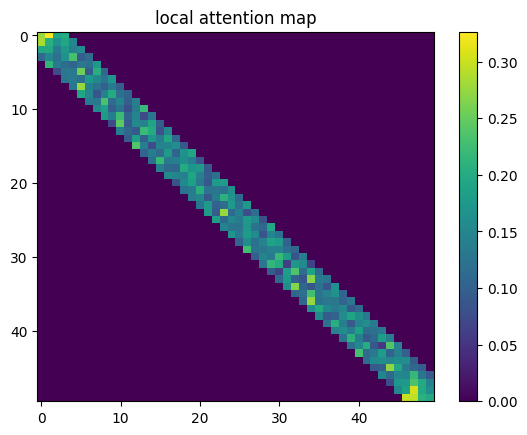

In [32]:
# シングルヘッドのアテンションマップを可視化
plt.imshow(attn_map[0].detach().cpu().numpy(), aspect='auto')
plt.colorbar()
plt.title("local attention map")
plt.show()